# Космический корабль Титаник

[Spaceship Titanic: predict which passengers are transported to an alternate dimension](https://www.kaggle.com/competitions/spaceship-titanic/)  

Задача взята из соревнования на kaggle для начинающих. Представляет собой классическую бинарную классификацию по мотивам известного датасета Titanic.  

Суть датасета и задачи заключается в следующем: космический корабль Титаник, двигавшийся к далёким звездным системам, попал в пространственно-временную аномалию, вследствие чего половина пассажиров попали в альтернативную реальность. По данным бортового компьютера **необходимо предсказать, попал ли тот или иной пассажир в эту самую параллельную реальность**, тем самым облегчив спасательную операцию.  

Данные представлены двумя файлами. В файле `train.csv` представлена информация о 8693 пассажирах в 14 колонках. В файле `test.csv` представлена информация о 4277 пассажирах с теми же колонками, но без целевой переменной. Собственно эти тестовые данные и нужно классифицировать, отправив на странице соревнования файл `submission.csv` с двумя колонками: `PassengerId` и `Transported`.  

**Описание** датасета:  

* `PassengerId` - Уникальный идентификатор пассажира, состоящий из двух частей `gggg_pp`, где `gggg` - это номер группы пассажира, а `pp` - номер самого пассажира в группе, люди в одной группе могут быть связаны, например, родством.  
* `HomePlanet` - Планета, с которой пассажир отбыл.  
* `CryoSleep` - Был ли пассажир в состоянии анабиоза.  
* `Cabin` - Номер каюты пассажира, состоит из трёх частей `deck/num/side` - палуба/номер/сторона, где сторона может быть или `P` для левого борта или `S` для правого.  
* `Destination` - Планета назначения, куда летит пассажир.  
* `Age` - Возраст.  
* `VIP` - Заплатил ли пассажир за VIP услуги.  
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Сколько заплатил пассажир за те или иные роскошные удобства.  
* `Name` - Имя и фамилия.  
* `Transported` - Был ли пассажир отправлен в альтернативное измерение. Это **целевая переменная**.  

## Подготовка  

### Импорт библиотек  

In [1]:
from os.path import join as path_join
from typing import NamedTuple

import pandas as pd
import numpy as np
import numpy.typing as npt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Установка констант  

In [2]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_FOLDS = 5
TARGET = 'Transported'

### Загрузка данных  

In [3]:
train_dataset = pd.read_csv(path_join('data', 'train.csv'))
test_dataset = pd.read_csv(path_join('data', 'test.csv'))

print('Размер тренировочного датасета:', train_dataset.shape)
print('Размер тестового датасета:', test_dataset.shape)

train_dataset.head()

Размер тренировочного датасета: (8693, 14)
Размер тестового датасета: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## EDA - разведочный анализ данных  

Распределение признаков, в первую очередь целевой переменной.  
Исследовать возможные выбросы.  
Парные графики.  
Что если прологарифмировать численные признаки?  

### Гипотезы  

* Имя и фамилия вряд ли повлияют на окончательный результат.  
* В численных колонках есть выбросы.  
* Категориальные переменные распределены по разному и где-нибудь есть дисбаланс, который стоит учитывать при разбиении датасета на тренировочную и тестовую выборки.  
* Коррелируемых признаков нет.  
* Пассажиры, бывшие в анабиозе, в большей степени были транспортированы в другое измерение.  
* 

### Основная информация о датасете и признаках  

In [4]:
data = train_dataset.copy()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
data.describe(include=['object', 'bool'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall,True
freq,1,4602,5439,8,5915,8291,2,4378


### Целевая переменная  

Целевая переменная `Transported` распределена равномерно.  

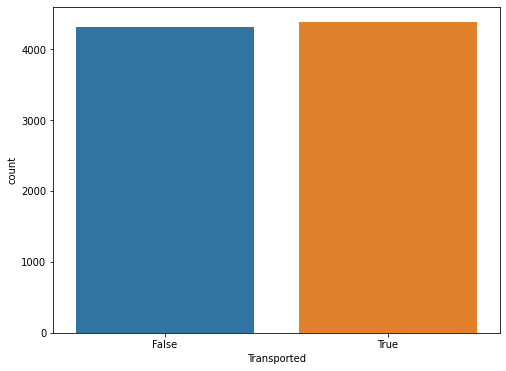

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(x='Transported', data=data)
plt.show()

### Более подробно  

`PassengerId`: данные в этой колонке составлены из двух чисел: номер группы и номер самого пассажира. Что если их разделить на `PassengerGroup` и `PassengerNumber`?  

In [9]:
data[['PassengerGroup', 'PassengerNumber']] = data['PassengerId'].str.split('_', expand=True)

data[['PassengerGroup', 'PassengerNumber']].astype(float).describe()

,PassengerGroup,PassengerNumber
count,8693.000000,8693.000000
mean,4633.389624,1.517773
std,2671.028856,1.054241
min,1.000000,1.000000
25%,2319.000000,1.000000
50%,4630.000000,1.000000
75%,6883.000000,2.000000
max,9280.000000,8.000000


`Name`: стоит ли как-то использовать имена? Уникальных значений имен и фамилий слишком много и маловероятно, что они будут полезны. Создать из них новые признаки сложно. От имён просто избавимся.  

In [10]:
data['FirstName'] = data['Name'].apply(lambda x: None if pd.isna(x) else x.split()[0])
data['LastName'] = data['Name'].apply(lambda x: None if pd.isna(x) else x.split()[1])

data[['FirstName', 'LastName']].describe()

,FirstName,LastName
count,8493,8493
unique,2706,2217
top,Idace,Casonston
freq,13,18


`Cabin`: если разделить данные в колонке, можно получить вполне полезные признаки.  
Пропуски в `CabinDeck` и `CabinSide` можно заполнить самым частым значением, а пропуски в `CabinNumber` неудобно заполнить ни средним, ни самым частым значением поэтому заполним его новым значением - тем, что больше макисмального на 1.  

In [11]:
data['CabinDeck'] = data['Cabin'].apply(lambda x: None if pd.isna(x) else x.split('/')[0])
data['CabinNumber'] = data['Cabin'].apply(lambda x: None if pd.isna(x) else x.split('/')[1])
data['CabinSide'] = data['Cabin'].apply(lambda x: None if pd.isna(x) else x.split('/')[2])

max_num = data['CabinNumber'].dropna().astype(int).max()
print('Максимальное значение в CabinNumber:', max_num)
data[['CabinDeck', 'CabinNumber', 'CabinSide']].describe()

Максимальное значение в CabinNumber: 1894


,CabinDeck,CabinNumber,CabinSide
count,8494,8494,8494
unique,8,1817,2
top,F,82,S
freq,2794,28,4288


`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: может оказаться полезным признак всех трат `TotalExpenses`. Этот новый признак показывает, что половина пассажиров так или иначе тратят деньги. Больше всего денег тратится на еду, а меньше всего на спа.

In [12]:

columns_for_summing = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
data['TotalExpenses'] = data[columns_for_summing].fillna(0.0).sum(axis=1)   

data[columns_for_summing + ['TotalExpenses']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalExpenses
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791,1440.866329
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000,1441.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


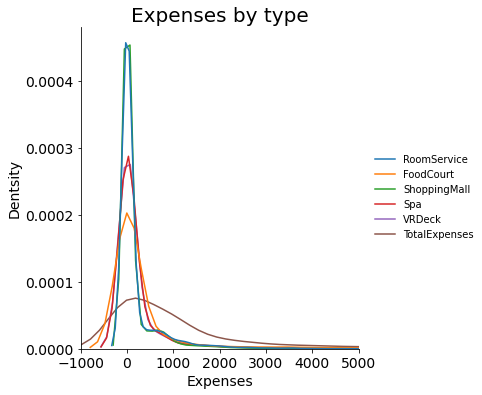

In [13]:
sns.displot(
    data[columns_for_summing + ['TotalExpenses']],
    kind="kde",
    common_norm=True
)

plt.title('Expenses by type', fontsize=20)
plt.xlabel('Expenses', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(-1000, 5000)
plt.show()

### Корреляции  

Из корреляций может быть интересно:  
* между `CryoSleep` и `Transported`;  
* между `CabinNumber` и `PassengerGroup` - и в целом зависимость понятна: пассажиры одной группы часто родственники, которые и занимают общую кабину.  

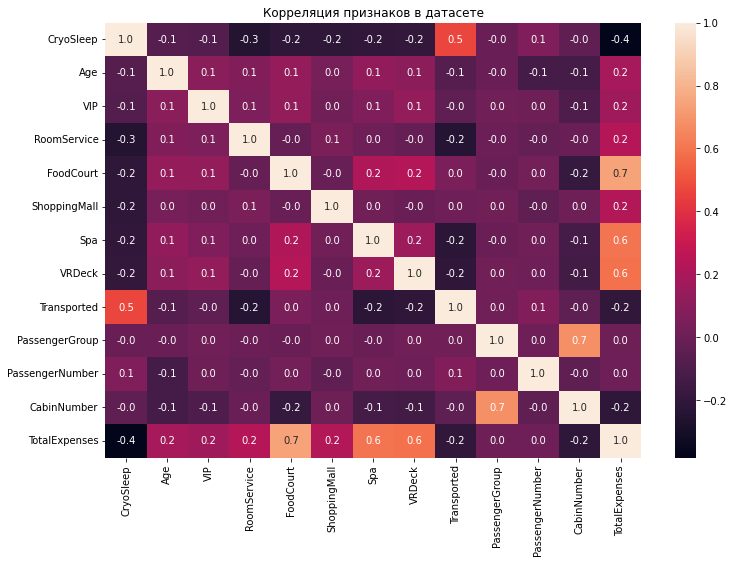

In [14]:
for column in data.drop(columns=['PassengerId']).columns:
    data[column] = data[column].astype(float, errors='ignore')

plt.figure(figsize=(12, 8))
plt.title('Корреляция признаков в датасете')
sns.heatmap(data.corr(), annot=True, fmt='0.1f')
plt.show()

Корреляция между `CryoSleep` и `Transported`:  
* большинство пассажиров в анабиозе были транспортированы в другое измерение;  
* те, кто не был в анабиозе, по большей части спаслись.  

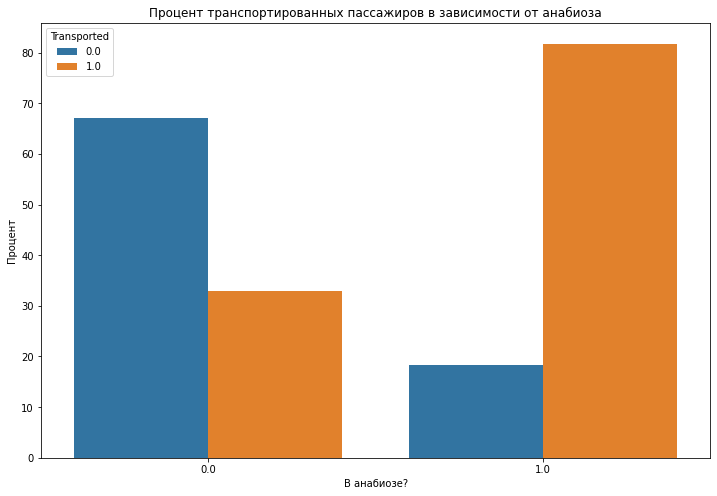

In [15]:
cryosleep_transported = (
    data.groupby(['CryoSleep'])['Transported']
    .value_counts(normalize=True)
    .rename('Percentage')
    .mul(100)
    .reset_index()
    .sort_values('CryoSleep'))

plt.figure(figsize=(12, 8))
plt.title('Процент транспортированных пассажиров в зависимости от анабиоза')
sns.barplot(x='CryoSleep', y='Percentage', hue='Transported', data=cryosleep_transported)
plt.xlabel('В анабиозе?')
plt.ylabel('Процент')
plt.show()

### Выбросы  

Взлянем на возможные выбросы в численных признаках. 

In [16]:
np.log(data[data['RoomService'] > 0]['RoomService'])

1       4.691348
2       3.761200
4       5.713733
6       3.737670
11      3.663562
          ...   
8675    6.937314
8682    5.480639
8683    4.454347
8686    0.000000
8692    4.836282
Name: RoomService, Length: 2935, dtype: float64

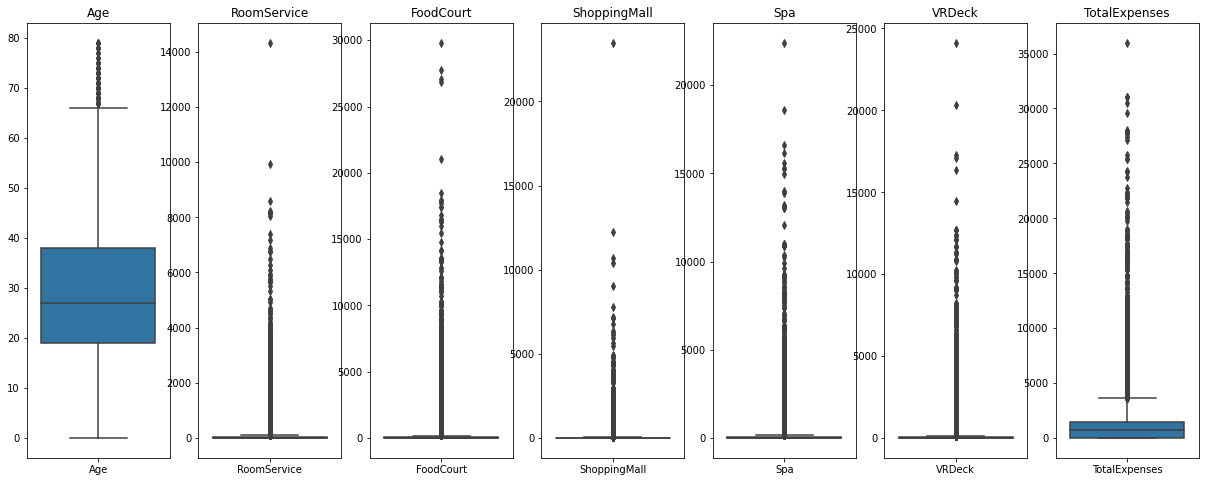

In [17]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalExpenses']

fig, axes = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(3*len(numerical_columns), 8))
for i, column in enumerate(numerical_columns):
    to_show = data[[column]]
    sns.boxplot(data=to_show, ax=axes[i])
    axes[i].set_title(column)

## Data Preparation  

Преобразование данных будет проводиться через pipeline библиотеки sklearn.  

In [4]:
class DataFrameColumnTransformer(ColumnTransformer): 
    """Кастомный трансформер колонок, который возвращает pd.DataFrame, а не массив numpy."""

    def get_names(self) -> list[str]:
        names = self.get_feature_names_out()
        names = [n.split('__')[-1] for n in names]
        return names

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        result = super().transform(X)
        names = self.get_names()
        for i, name in enumerate(names):
            X[name] = result[:, i]
            X[name] = X[name].astype(float, errors='ignore')
        return X
    
    def fit_transform(self, X: pd.DataFrame, y: pd.Series | None = None) -> pd.DataFrame:
        result = super().fit_transform(X, y)
        names = self.get_names()
        for i, name in enumerate(names):
            X[name] = result[:, i]
            X[name] = X[name].astype(float, errors='ignore')
        return X

### Feature Engineering - создание признаков  

Информация в некоторых колонках содержит больше одного признака. Их стоит разделить.  
Колонку `PassengerId` можно разделить на группу `PassengerGroup` и номер пассажира `PassengerNumber`.  
Колонку `Cabin` можно разделить на палубу `CabinDeck`, номер `CabinNumber` и сторону `CabinSide`.  

Можно создать признак `AgeCategory`, показывающий возрастную группу пассажира.  
Также было бы неплохо создать признак, содержащий общую сумму трат `TotalExpenses`.  

Созданные признаки привести к нужным типам.  

In [5]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    """Создаёт новые признаки: 
    * `PassengerGroup` и `PassengerNumber` из `PassengerId`; 
    * `CabinDeck`, `CabinNumber` и `CabinSide` из `Cabin`; 
    * `TotalExpenses` как сумма `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` и `VRDeck`.
    """

    data = data.copy()

    # Splitting columns PassengerId and Cabin
    data[['PassengerGroup', 'PassengerNumber']] = data['PassengerId'].str.split('_', expand=True)
    data[['CabinDeck', 'CabinNumber', 'CabinSide']] = data['Cabin'].str.split('/', expand=True)

    # Creating AgeCategory feature 
    def get_age_category(age: float) -> str: 
        if age < 0: 
            return float('nan')
        elif age <= 25: 
            return 'young'
        elif age <= 50: 
            return 'average'
        else: 
            return 'old'
    data['AgeCategory'] = data['Age'].apply(get_age_category)

    # Creating TotalExpenses feature
    columns_for_summing = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    data['TotalExpenses'] = data[columns_for_summing].fillna(0.0).sum(axis=1)    

    # Set new features as float type
    columns_to_float = ['PassengerGroup', 'PassengerNumber', 'CabinNumber']
    data[columns_to_float] = data[columns_to_float].astype(float)

    return data

features_creator = FunctionTransformer(create_features)

### Заполнение пропусков  

Во всех колонках, кроме id пассажира и целевой переменной, есть пропуски.  
Пропуски в колонке `Age` можно заполнить средним значением.  
Пропуски в колонках `HomePlanet`, `CryoSleep`, `Destination`, `VIP`, `CabinDeck`, `CabinSide`, `AgeCategory` можно заполнить самым частым значением.  
Пропуски в колонках `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` можно заполнить 0, как самым частым значением, потому что роскошные удобства может себе позволить лишь небольшой круг людей.  
Пропуски в колонке `CabinNumber` можно заполнить новым значением, большим максимального на 1.  

In [6]:
class MaxMoreImputer(BaseEstimator, TransformerMixin):
    """Класс для заполнения пропущенных значений. 
    Пустые значения заполняются максимальным значением колонки, увеличенных на значение `step`.
    """

    def __init__(self, step: float = 1.0) -> None:
        super().__init__()
        self.step = step
        self._features_names = None
        self._impute_value = None
    
    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike | None = None) -> 'MaxMoreImputer':
        self._impute_value = X.astype(float).max()
        self._features_names = X.columns
        return self
    
    def transform(self, X: npt.ArrayLike, y: npt.ArrayLike | None = None) -> np.ndarray:
        check_is_fitted(self, '_impute_value')
        return X.fillna(self._impute_value + self.step)
    
    def get_feature_names_out(self, input_features: npt.ArrayLike | None = None) -> np.ndarray:
        check_is_fitted(self, '_features_names')
        return self._features_names

In [7]:
missings_filler = DataFrameColumnTransformer(transformers=[
    ('age_imputer', SimpleImputer(strategy='mean'), ['Age']), 
    ('mode_imputer', SimpleImputer(strategy='most_frequent'), 
     ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide', 'AgeCategory']), 
    ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0.0), 
     ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']), 
    ('cabin_number_imputer', MaxMoreImputer(), ['CabinNumber']), 
], remainder='passthrough')

### Обработка выбросов  

Обработка выбросов в колонке `Age`: те значения, что меньше нижней границы интерквартального размаха, приравнять к этой нижней границе, те, что выше - к верхней границе.  
Искать выбросы в колонках `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`, `TotalExpenses` без учёта нулевого значения.  

Может быть произвести логарифмирование?

In [8]:
# Пока ничего, нужно провести анализ сперва

### Нормализация численных переменных  

Стандартизируем числовые признаки с помощью StandardScaler.  

In [9]:
# используется column transformer, чтобы разделить 
# шаги нормализации и кодирования категориальных признаков

normalizer = DataFrameColumnTransformer(transformers=[
    ('scaler', StandardScaler(), 
     ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
      'PassengerGroup', 'PassengerNumber', 'CabinNumber', 'TotalExpenses']),  
], remainder='passthrough')

### Кодирование категориальных переменных  



In [10]:
# используется column transformer, чтобы разделить 
# шаги нормализации и кодирования категориальных признаков

onehot_encoder = DataFrameColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore', drop='if_binary'), 
     ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide', 'AgeCategory']), 
], remainder='passthrough')

### Удаление ненужных колонок  



In [11]:
def remove_columns(data: pd.DataFrame) -> pd.DataFrame:
    """Удаляет ненужные колонки: 
    `PassengerId`, `HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP`, `Name`, `CabinDeck`, `CabinSide`, `AgeCategory`.
    """

    data = data.copy()

    columns_to_drop = ['PassengerId', 'Cabin', 'Name', 'HomePlanet', 'Destination', 
                       'CabinDeck', 'CabinSide', 'AgeCategory', 'CryoSleep', 'VIP']  
    data = data.drop(columns=columns_to_drop)

    return data

columns_remover = FunctionTransformer(remove_columns)

### Соберём пайплайн  

Соберём все запланированные шаги подготовки данных в единый пайплайн.  

In [12]:
x = train_dataset.copy() 
y = x.pop('Transported')

In [13]:
preprocessor = Pipeline(steps=[
    ('feature_engineering', features_creator), 
    ('filling_missing', missings_filler), 
    # ('outliers_handling', ), 
    ('normalization', normalizer), 
    ('onehot_encoding', onehot_encoder), 
    ('feature_selection', columns_remover), 
])

## Modeling  

Не забыть выбор метрики или даже нескольких.  

Модели на выбор: 
    * логистическая регрессия;  
    * метод опорных векторов;  
    * случайный лес;  
    * градиентный бустинг;  
    * метод k-ближайших соседей;
    * catboost?


### Разделение данных  

In [14]:
x = train_dataset.copy()
y = x.pop(TARGET)

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'train shapes: {x_train.shape} and {y_train.shape}')
print(f'valid shapes: {x_valid.shape} and {y_valid.shape}')

train shapes: (6954, 13) and (6954,)
valid shapes: (1739, 13) and (1739,)


### Выбор метрик  

Так как это классификация и целевая переменная распределена равномерно, будем использовать в качестве основной метрики точность - `accuracy_score`. Но также взглянем и на другие метрики: precision, recall, f1, roc-auc.

In [15]:
class Metrics(NamedTuple):
    """Класс для сохранения и передачи информации о метриках."""
    train_accuracy: float
    test_accuracy: float
    train_precision: float
    test_precision: float
    train_recall: float
    test_recall: float
    train_f1: float
    test_f1: float
    train_roc_auc: float
    test_roc_auc: float

In [16]:
def get_metrics(model: BaseEstimator, x_train: npt.ArrayLike, x_valid: npt.ArrayLike, 
                y_train: npt.ArrayLike, y_valid: npt.ArrayLike) -> Metrics:
    """Рассчитывает и возвращает метрик `accuracy`, `precision`, `recall`, `f1`, `roc_auc`."""

    train_y_true, test_y_true = y_train, y_valid
    train_y_pred = model.predict(x_train)
    test_y_pred = model.predict(x_valid)

    return Metrics(
        train_accuracy=accuracy_score(train_y_true, train_y_pred), 
        test_accuracy=accuracy_score(test_y_true, test_y_pred), 
        train_precision=precision_score(train_y_true, train_y_pred), 
        test_precision=precision_score(test_y_true, test_y_pred), 
        train_recall=recall_score(train_y_true, train_y_pred), 
        test_recall=recall_score(test_y_true, test_y_pred), 
        train_f1=f1_score(train_y_true, train_y_pred), 
        test_f1=f1_score(test_y_true, test_y_pred), 
        train_roc_auc=roc_auc_score(train_y_true, train_y_pred), 
        test_roc_auc=roc_auc_score(test_y_true, test_y_pred), 
    )

In [17]:
metrics = pd.DataFrame(index=Metrics._fields)

### Baseline  

В качестве бейзлайн модели возъмём простую модель k-ближайших соседей.  

In [18]:
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', KNeighborsClassifier()), 
])

baseline_model.fit(x_train, y_train)
metrics['baseline_knn'] = get_metrics(baseline_model, x_train, x_valid, y_train, y_valid)

metrics

,baseline_knn
train_accuracy,0.849727
test_accuracy,0.757907
train_precision,0.858604
test_precision,0.756453
train_recall,0.839714
test_recall,0.767654
train_f1,0.849054
test_f1,0.762012
train_roc_auc,0.849793
test_roc_auc,0.757811


### Обучение нескольких моделей  

Обучим несколько моделей с параметрами по умолчанию, выберем лучшую из них и уже её будем оптимизировать далее.  

In [19]:
models = [
    RandomForestClassifier(random_state=RANDOM_STATE), 
    GradientBoostingClassifier(random_state=RANDOM_STATE), 
    LogisticRegression(solver='liblinear'), 
    SVC(random_state=RANDOM_STATE)
]

best_score = 0.0
best_model = None

In [20]:
for model in models:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    score = cross_val_score(pipe, x, y, cv=N_FOLDS, scoring='accuracy')
    if score.mean() > best_score:
        best_score = score.mean()
        best_model = pipe
    print(f'model: {type(model).__name__}, acc_mean: {score.mean():0.4f}, acc_std: {score.std():0.4f}.')

model: RandomForestClassifier, acc_mean: 0.7676, acc_std: 0.0381.
model: GradientBoostingClassifier, acc_mean: 0.7062, acc_std: 0.0903.
model: LogisticRegression, acc_mean: 0.7852, acc_std: 0.0063.
model: SVC, acc_mean: 0.7876, acc_std: 0.0273.


In [21]:
print(f'Лучшая модель c точностью {best_score:0.4f}:', type(best_model['classifier']).__name__)

Лучшая модель c точностью 0.7876: SVC


### Оптимизация гиперпараметров модели SVC

Лучшей моделью оказывается метод опорных векторов - Support Vector Classification. Сохраним результаты модели до оптимизации.  

In [22]:
svc_model = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('svc', SVC(random_state=RANDOM_STATE))
])

svc_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('feature_engineering',
                                  FunctionTransformer(func=<function create_features at 0x7ff5fe3b6290>)),
                                 ('filling_missing',
                                  DataFrameColumnTransformer(remainder='passthrough',
                                                             transformers=[('age_imputer',
                                                                            SimpleImputer(),
                                                                            ['Age']),
                                                                           ('mode_imputer',
                                                                            SimpleImputer(strategy='most_frequent'),
                                                                            ['HomePlanet',
                                                                             'CryoSleep',
                                                                             'Des...
                                  DataFrameColumnTransformer(remainder='passthrough',
                                                             transformers=[('encoder',
                                                                            OneHotEncoder(drop='if_binary',
                                                                                          handle_unknown='ignore',
                                                                                          sparse=False),
                                                                            ['HomePlanet',
                                                                             'CryoSleep',
                                                                             'Destination',
                                                                             'VIP',
                                                                             'CabinDeck',
                                                                             'CabinSide',
                                                                             'AgeCategory'])])),
                                 ('feature_selection',
                                  FunctionTransformer(func=<function remove_columns at 0x7ff5c7bca290>))])),
                ('svc', SVC(random_state=42))])

In [23]:
metrics['svc'] = get_metrics(svc_model, x_train, x_valid, y_train, y_valid)
metrics

,baseline_knn,svc
train_accuracy,0.849727,0.822261
test_accuracy,0.757907,0.791259
train_precision,0.858604,0.816201
test_precision,0.756453,0.780196
train_recall,0.839714,0.834857
test_recall,0.767654,0.816629
train_f1,0.849054,0.825424
test_f1,0.762012,0.797997
train_roc_auc,0.849793,0.822177
test_roc_auc,0.757811,0.791009


С помощью GridSearch оптимизируем гиперпараметры модели SVC. А затем обучим модель с оптимизированными параметрами.

In [ ]:
grid_parameters = {
    'svc__C': [0.001, 1.0, 100], 
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
}

grid_search = GridSearchCV(svc_model, param_grid=grid_parameters, cv=N_FOLDS)
grid_search.fit(x, y)

In [40]:
print('Лучшие параметры для SVC:')
print(grid_search.best_params_)

{'svc__C': 100, 'svc__kernel': 'linear'}

In [24]:
# Создадим и обучим оптимизированную модель

svc_model_optimized = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('svc', SVC(C=100, kernel='linear', random_state=RANDOM_STATE))
])

svc_model_optimized.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('feature_engineering',
                                  FunctionTransformer(func=<function create_features at 0x7ff5fe3b6290>)),
                                 ('filling_missing',
                                  DataFrameColumnTransformer(remainder='passthrough',
                                                             transformers=[('age_imputer',
                                                                            SimpleImputer(),
                                                                            ['Age']),
                                                                           ('mode_imputer',
                                                                            SimpleImputer(strategy='most_frequent'),
                                                                            ['HomePlanet',
                                                                             'CryoSleep',
                                                                             'Des...
                                  DataFrameColumnTransformer(remainder='passthrough',
                                                             transformers=[('encoder',
                                                                            OneHotEncoder(drop='if_binary',
                                                                                          handle_unknown='ignore',
                                                                                          sparse=False),
                                                                            ['HomePlanet',
                                                                             'CryoSleep',
                                                                             'Destination',
                                                                             'VIP',
                                                                             'CabinDeck',
                                                                             'CabinSide',
                                                                             'AgeCategory'])])),
                                 ('feature_selection',
                                  FunctionTransformer(func=<function remove_columns at 0x7ff5c7bca290>))])),
                ('svc', SVC(C=100, kernel='linear', random_state=42))])

In [25]:
# И сохраним её метрики 

metrics['svc_optimized'] = get_metrics(svc_model_optimized, x_train, x_valid, y_train, y_valid)
metrics

,baseline_knn,svc,svc_optimized
train_accuracy,0.849727,0.822261,0.800259
test_accuracy,0.757907,0.791259,0.789534
train_precision,0.858604,0.816201,0.792950
test_precision,0.756453,0.780196,0.775269
train_recall,0.839714,0.834857,0.816286
test_recall,0.767654,0.816629,0.821185
train_f1,0.849054,0.825424,0.804449
test_f1,0.762012,0.797997,0.797566
train_roc_auc,0.849793,0.822177,0.800152
test_roc_auc,0.757811,0.791009,0.789222


Далее обучим модель на всем датасете и сформируем предсказания для тестовой выборки.

In [26]:
svc_model_optimized.fit(x, y)

test_predictions = pd.DataFrame({
    'PassengerId': test_dataset['PassengerId'],
    'Transported': svc_model_optimized.predict(test_dataset),
})
print('test_predictions.shape', test_predictions.shape)
test_predictions.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


## Результаты

Сохраним результаты предсказаний на тестовой выборке и отправим их на kaggle.

In [29]:
filename = 'submission1.csv'
test_predictions.to_csv(path_join('data', filename), index=False)

Первая попытка дала результат: место в рейтинге - 1146, точность - 0.79401.